In [1]:
"""Does Ptolemy hold for angles between vectors?
No - of course it does not.
"""

'Does Ptolemy hold for angles between vectors?\n\n'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from scipy.stats import pearsonr, zscore
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
from dataclasses import dataclass
import numpy.testing as npt

import sys

sys.path.append("/home/elayn/epix/metric_spaces/")

from numerical.metric_test import MetricTest, NoVarianceError

In [7]:
def d(x, y):
    return np.arccos(np.sum(x * y) / np.linalg.norm(x) / np.linalg.norm(y))

100%|██████████| 10000/10000 [00:00<00:00, 116625.07it/s]


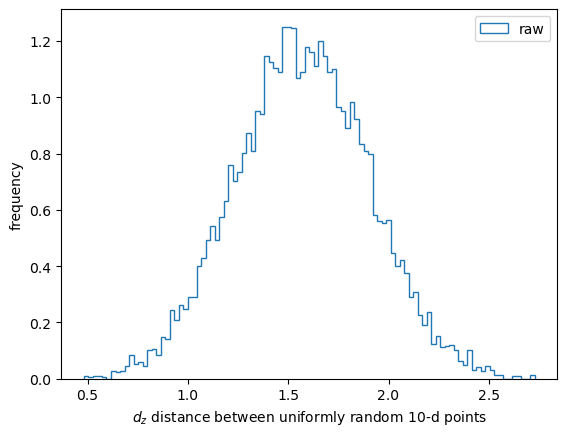

In [10]:
DIMS = 10
SAMPLES = 10000

dists = defaultdict(list)

for _ in tqdm(range(SAMPLES)):
    vecs = np.random.rand(2, DIMS) * 37 - 18.5

    dists["raw"].append(d(*vecs))

for k, v in dists.items():
    plt.hist(v, density=True, histtype="step", label=k, bins=100)
plt.legend()
plt.xlabel(f"$d_z$ distance between uniformly random {DIMS}-d points")
plt.ylabel("frequency")
plt.show()

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/tmp/ipykernel_151775/1395935746.py:2: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_151775/1395935746.py:2: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_151775/1395935746.py:2: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_151775/1395935746.py:2: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_151775/1395935746.py:2: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_151775/1395935746.py:2: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_151775/1395935746.py:2: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_151775/1395935746.py:2: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_151775/1395935746.py:2: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_151775/1395935746.py:2: Ru

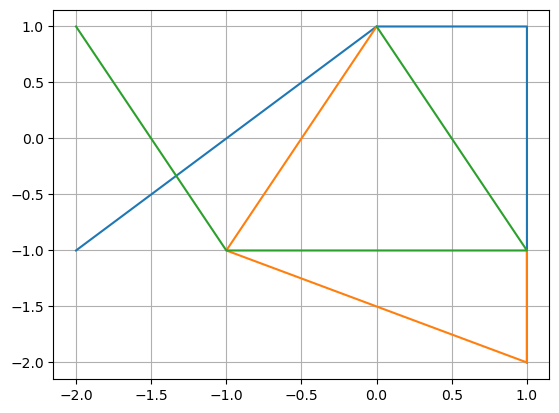

In [32]:
DIMS = 2


def generate_discrete_vecs(*number, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    return rng.integers(-2, 2, size=[*number, DIMS])


def generate_float_vecs(*number, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    return rng.random(size=[*number, DIMS]) * 37 - 18.5


test = MetricTest(d, generate_discrete_vecs)
res = test.run_test(30000)

for i in range(3):
    _, points = res[i]
    plt.plot(*np.asarray(points).T)
plt.grid()

array([[  1,  -7],
       [ 11, -15],
       [ 16,   0],
       [-12,   2]])

100%|█████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 9126.25it/s]


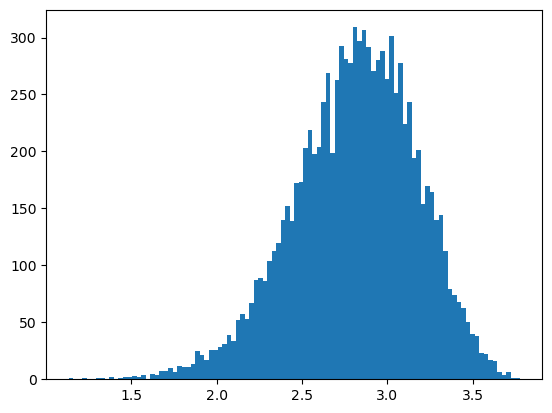

In [12]:
@dataclass
class MultivariateTimeSeries:
    discrete = True

    # number of sampels in a series
    WINDOW_LEN: int
    # number of time series
    N_SERIES: int

    def generate(self, *number, rng=None):
        if rng is None:
            rng = np.random.default_rng()
        shape = (*number, self.N_SERIES, self.WINDOW_LEN)
        if self.discrete:
            return rng.integers(-20, 20, size=shape)
        else:
            return rng.random(size=shape) * 37 - 18.5

    def __call__(self, *number, rng=None):
        return self.generate(*number, rng=rng)


mts_generator = MultivariateTimeSeries(5, 4)
mts_generator.discrete = True


def mvts_distance(x, y):
    n_series, _ = x.shape
    dist = [d(x[s], y[s]) ** 2 for s in range(n_series)]
    return np.sqrt(np.sum(dist))


def mvts_distance_chebichev(x, y):
    n_series, _ = x.shape
    dist = [d(x[s], y[s]) for s in range(n_series)]
    return np.max(dist)


def mvts_distance_taxi(x, y):
    n_series, _ = x.shape
    dist = [d(x[s], y[s]) for s in range(n_series)]
    return np.sum(dist)


samples_dists = [mvts_distance(*mts_generator(2)) for _ in tqdm(range(10000))]
plt.hist(samples_dists, bins=100)
plt.show()

In [20]:
mts_generator = MultivariateTimeSeries(5, 4)
mts_generator.discrete = True

test = MetricTest(mvts_distance, mts_generator)
samples_per_min = 760_000 * 2 // 3
n = samples_per_min * 30
res = test.run_test(n)
np.unique([msg for msg, _ in res], return_counts=True)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  88 tasks      | elapsed:   10.5s
[Parallel(n_jobs=20)]: Done 248 tasks      | elapsed:   27.3s
[Parallel(n_jobs=20)]: Done 472 tasks      | elapsed:   54.7s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:  1.5min
[Parallel(n_jobs=20)]: Done 1112 tasks      | elapsed:  2.2min
[Parallel(n_jobs=20)]: Done 1528 tasks      | elapsed:  3.0min
[Parallel(n_jobs=20)]: Done 2008 tasks      | elapsed:  3.9min
[Parallel(n_jobs=20)]: Done 2552 tasks      | elapsed:  5.0min
[Parallel(n_jobs=20)]: Done 3160 tasks      | elapsed:  6.1min
[Parallel(n_jobs=20)]: Done 3832 tasks      | elapsed:  7.4min
[Parallel(n_jobs=20)]: Done 4568 tasks      | elapsed:  8.8min
[Parallel(n_jobs=20)]: Done 5368 tasks      | elapsed: 10.3min
[Parallel(n_jobs=20)]: Done 6232 tasks      | elapsed: 12.0min
[Parallel(n_jobs=20)]: Done 7160 tasks      | elapsed: 13.7min
[Parallel(n_jobs=20)]: Done 8152 tasks      |

(array(['skipped'], dtype='<U7'), array([115]))

In [ ]:
res[0]

In [ ]:
# this raises a no variance error:
vecs = np.asarray(
    (
        np.array([[-14, -1, 1, 5], [-20, -4, 9, 14], [-16, 8, -10, -19]]),
        np.array([[16, 16, 16, 16], [-16, 15, 13, -15], [-8, -3, 4, 3]]),
        np.array([[4, 14, 12, -12], [4, -14, -4, 10], [9, -17, -19, -20]]),
        np.array([[19, -11, -17, 16], [-8, -14, 14, 10], [-5, 4, -14, 15]]),
    )
)
np.std(vecs, axis=2, ddof=1)

In [ ]:
def histogram_overlap(data_a, data_b, bins=50):
    both = np.hstack((data_a, data_b))
    bins = np.histogram_bin_edges(both, bins=bins)
    a, _ = np.histogram(data_a, bins)
    b, _ = np.histogram(data_b, bins)
    overlap_absolute = np.vstack((a, b)).min(axis=0).sum()
    bin_width = bins[1] - bins[0]
    return overlap_absolute / len(data_a)

In [ ]:
# here be dragons

lb = defaultdict(list)
for _ in tqdm(range(SAMPLES)):
    vecs = np.random.rand(4, DIMS) * 37 - 18.5
    x, y, z, _ = vecs
    lb["triangle"].append(np.abs(d(x, y) - d(z, y)))

    p1, p2, q, o = vecs
    numerator = d(p1, o) * d(p2, q) - d(p1, q) * d(p2, o)
    quotient = d(p1, p2)
    lb["ptolemy"].append(np.abs(numerator) / quotient)

    p1, p2, q, o = vecs
    p1_lb = np.abs(d(p1, o) - d(p1, q))
    p2_lb = np.abs(d(p2, o) - d(p2, q))
    lb["two_triangle"].append(max(p1_lb, p2_lb))

In [ ]:
exact_dists = dists["raw"]
plt.hist(exact_dists, density=True, label="exact_distances", bins=50)

print("overlaps")
for k, v in lb.items():
    plt.hist(v, density=True, histtype="step", label="lb_" + k, bins=50)
    print(k, histogram_overlap(v, exact_dists))

# best of all
everything = np.asarray([v for _, v in lb.items()])
best = everything.max(axis=0)
plt.hist(best, density=True, histtype="step", label="best_lb", bins=50)
print("max_lb", histogram_overlap(best, exact_dists))

plt.legend()
plt.xlabel(f"$d_z$ distance between uniformly random {DIMS}-d points")
plt.ylabel("frequency")
plt.show()

In [ ]:
# using four pivots:
# we can do that because points are uniformly random
pto_4_piv = np.array(lb["ptolemy"]).reshape(4, -1)
pto_4_piv = pto_4_piv.max(axis=0)
plt.hist(best, density=True, histtype="step", label="best_lb", bins=50)
plt.hist(pto_4_piv, density=True, histtype="step", label="pto_4_piv", bins=50)

In [ ]:
dists = []
for _ in tqdm(range(100000)):
    vecs = np.random.randint(-20, 20, size=[2, 5])
    # vecs = zscore(vecs,axis=1)
    dists.append(d(*vecs))

plt.hist(dists, bins=100)

In [ ]:
dists = []

In [ ]:
for _ in tqdm(range(100000)):
    vecs = np.random.randint(-20, 20, size=[4, 5])
    # vecs = vecs - vecs.mean(axis=0)
    x, y, z, k = vecs
    if triangle_violation(x, y, z) > 1e-3:
        print(x, y, z)
    if pto_violation(x, y, z, k) > 1e-3:
        print("pto violation", x, y, z)

In [ ]:
def cos_dist_triangle_inequality(x, y, z):
    def d_t(a, b):
        return np.sqrt(2 - 2 * cos_theta(a, b))

    lhs = d_t(x, y)
    rhs = d_t(x, z) + d_t(z, y)
    # lhs <= rhs
    violation = lhs - rhs
    return violation


side_diffs = []
for _ in tqdm(range(100000)):
    vecs = np.random.randint(-20, 20, size=[4, 3])
    vecs = vecs / np.linalg.norm(vecs, axis=0)  # - vecs.mean(axis=0)
    x, y, z, k = vecs
    diff = cos_dist_triangle_inequality(x, y, z)
    side_diffs.append(diff)
    if diff > 1e-3:
        print(diff, x, y, z)
        break


plt.hist(side_diffs)

In [ ]:
def d(corr, m=10):
    return np.sqrt(2 * m * (1 - corr))


def is_triangle_inequal(x_var, y_var, z_var, xy_cov, xz_cov, yz_cov):
    xy_corr = xy_cov / np.sqrt(x_var * y_var)
    xz_corr = xz_cov / np.sqrt(x_var * z_var)
    yz_corr = yz_cov / np.sqrt(z_var * y_var)
    return d(xy_cov) <= d(xz_cov) + d(yz_cov)

In [ ]:
for _ in tqdm(range(10000)):
    vars = np.random.rand(3) * 100
    covars = (np.random.rand(3) - 0.5) * 100
    if not is_triangle_inequal(*vars, *covars):
        print("violation")
        break

x, y = np.random.randint(-20, 20, size=[2, 5])
x, y = x - np.mean(x), y - np.mean(y)

corr(x, y), cos_theta(x, y)

In [ ]:
np.linalg.norm(x)

In [ ]:
while True:
    x, y = np.random.randint(-20, 20, size=[2, 4])
    if np.abs(corr(x, y)) < 1e-5:
        break

In [ ]:
x, y, corr(x, y)

In [ ]:
zscore(x), zscore(y)

In [ ]:
d(x, y)